<a href="https://colab.research.google.com/github/Shruti-Raj-Vansh-Singh/Chest-X-Ray-Classification/blob/main/Chest_X_ray_pneumothrox_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pneumothrox
It is the collapse of the lungs. In this due to sime leakage in the lungs that can be because of some rent the oxygen that enters the lungs gets collected in the pleural cavity that decreases the size and capacity of the lungs which in turn affects the circulation of oxygen in the blood as most of the oxygen gets collected in the cavity. It usually intensifies when postive pressure ventilator is used. \
It can be treated by inserting a chest tube to release the captivated oxygen and restore blood flow.

## Dataset used
The dataset used is the [SIIM-ACR Pneumothrox Segemntation](https://link.springer.com/article/10.1007/s10278-019-00299-9) dataset. 

links
https://journal.chestnet.org/article/S0012-3692(12)60236-0/fulltext   \
https://link.springer.com/article/10.1007/s10278-019-00299-9


In [73]:
!pip install fastai==2.3.0

In [74]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

The images used in this notebook are DICOM(Digital Imaging and Communications in Medicine). For that we will use pydicom library to handle the data. \
\
To use fastai.medical.imaging we need the following dependencies:
pydicom, kornia, opencv, sciki-image

In [ ]:
!pip install pydicom kornia opencv-python scikit-image

     |████████████████████████████████| 1.9MB 8.2MB/s 
     |████████████████████████████████| 286kB 45.6MB/s 


In [76]:
from fastai import *
from fastai.vision.all import *
from fastai.data.all import *
from fastai.medical.imaging import *


import pydicom
import pandas as pd

# Data Visualization


Importing our dataset

In [77]:
dataset = untar_data(URLs.SIIM_SMALL)

In [78]:
print(dataset)

/root/.fastai/data/siim_small


In [79]:
!apt install tree
!tree /root/.fastai/data/siim_small --dirsfirst --filelimit 10

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/root/.fastai/data/siim_small
├── train
│   ├── No Pneumothorax [175 entries exceeds filelimit, not opening dir]
│   └── Pneumothorax [75 entries exceeds filelimit, not opening dir]
└── labels.csv

3 directories, 1 file


Load the path of the dicom images retreived using get_dicom_files()

In [80]:
#stores the path of each dicom file
items = get_dicom_files(dataset/'train')

In [81]:
print(items[1])

/root/.fastai/data/siim_small/train/No Pneumothorax/000002.dcm


Splitting our data into training and validation dataset.

In [82]:
train, val = RandomSplitter(valid_pct=0.1,seed =42)(items)

Pydicom is a python package for parsing DICOM files, making it easier to access the header of the DICOM as well as coverting the raw pixel_data into pythonic structures for easier manipulation. fastai.medical.imaging uses pydicom.dcmread to load the DICOM file.

In [83]:

#to load the dicom file that contains the details of the patient
patient = 2
xray_sample = items[patient].dcmread()
#view header
print(xray_sample)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3935.1517875180.205912
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3935.1517875180.205912
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        



Some key pointers on the tag information above:

1. **Pixel Data** (7fe0 0010) - This is where the raw pixel data is stored. The order of pixels encoded for each image plane is left to right, top to bottom, i.e., the upper left pixel (labeled 1,1) is encoded first
2. **Photometric Interpretation** (0028, 0004) - also known as color space. In this case it is MONOCHROME2 where pixel data is represented as a single monochrome image plane where low values=dark, high values=bright. If the colorspace was MONOCHROME then the low values=bright and high values=dark info.
3. **Samples per Pixel** (0028, 0002) - This should be 1 as this image is monochrome. This value would be 3 if the color space was RGB for example
4. **Bits Stored **(0028 0101) - Number of bits stored for each pixel sample. Typical 8 bit images have a pixel range between 0 and 255
5. **Pixel Represenation**(0028 0103) - can either be unsigned(0) or signed(1)
6. **Lossy Image Compression **(0028 2110) - 00 image has not been subjected to lossy compression. 01 image has been subjected to lossy compression.
7. **Lossy Image Compression Method** (0028 2114) - states the type of lossy compression used (in this case ISO_10918_1 represents JPEG Lossy Compression)
8. **Pixel Data** (7fe0, 0010) - Array of 161452 elements represents the image pixel data that pydicom uses to convert the pixel data into an image.
\
[more info](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.3.html#sect_C.7.6.3.1.4)


In [84]:
#pixel data
xray_sample.PixelData[:200]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0\xb8c\x01\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x03\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x01\x00\x05\x06\x08\x07\t\xff\xc4\x00c\x10\x00\x01\x03\x03\x03\x02\x03\x04\x04\x08\x05\x0b\x11\x07\x02\x07\x01\x00\x02\x11\x03!1\x04\x12A\x05Q\x06aq\x13"\x81\x91\x072\xa1\xb1\x08\x14\x16B\xb3\xc1\xd1\xd2\x15&6\x95\xe1#$%EReu\x92\xb2\xf0\xf1\t'

In [85]:
#more convinient way to interpret pixeldata in the form of pixel array that is a numpy.ndarray with the help of dicom
xray_sample.pixel_array, xray_sample.pixel_array.shape

(array([[  0,   0,   0, ...,  24,  30,  11],
        [  0,   0,   0, ...,  51,  55,  34],
        [  0,   1,   1, ...,  49,  51,  29],
        ...,
        [  1,   1,   1, ..., 165, 166,  91],
        [  1,   1,   1, ..., 165, 165, 102],
        [  1,   1,   1, ...,  77,  90,  44]], dtype=uint8), (1024, 1024))

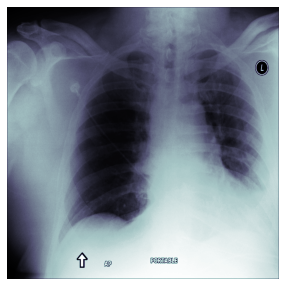

In [86]:
xray_sample.show()

In [87]:
#converting the data into all the info in the dicom image to a pandas dataframe using pandas from_dicoms() function

xray_dataframe = pd.DataFrame.from_dicoms(items)
xray_dataframe.head(5)

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,PatientName,PatientID,PatientBirthDate,PatientSex,PatientAge,BodyPartExamined,ViewPosition,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,InstanceNumber,PatientOrientation,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,fname,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.2231.1517875171.730913,19010101,000000.00,,CR,WSD,,view: PA,"(8, 4, 0, 6, 5, b, 2, 2, -, 9, 6, 7, f, -, 4, 9, 7, f, -, 8, 0, 8, 7, -, 6, 7, b, 0, f, f, 1, 7, 7, 5, a, 1)",84065b22-967f-497f-8087-67b0ff1775a1,,M,73,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.2231.1517875171.730912,1.2.276.0.7230010.3.1.3.8323329.2231.1517875171.730911,,1,1,,1,MONOCHROME2,1024,1024,0.143,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000164.dcm,1,0.143,0,255,123.182117,73.225120,0.254707
1,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789,19010101,000000.00,,CR,WSD,,view: PA,"(8, 5, 0, d, d, e, b, 3, -, 7, 3, a, c, -, 4, 5, e, 0, -, 9, 6, b, f, -, 7, d, 2, 7, 5, b, c, 8, 3, 7, 8, 2)",850ddeb3-73ac-45e0-96bf-7d275bc83782,,F,52,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.11028.1517875229.983788,1.2.276.0.7230010.3.1.3.8323329.11028.1517875229.983787,,1,1,,1,MONOCHROME2,1024,1024,0.143,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000002.dcm,1,0.143,0,250,114.524713,70.752315,0.326269
2,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.3935.1517875180.205912,19010101,000000.00,,CR,WSD,,view: AP,"(8, 5, e, 5, 1, 8, 0, 3, -, 3, 3, 4, 9, -, 4, 4, 2, e, -, a, b, 7, 0, -, a, 7, 5, 7, 8, d, e, 1, 4, 6, 2, e)",85e51803-3349-442e-ab70-a7578de1462e,,M,64,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.3935.1517875180.205911,1.2.276.0.7230010.3.1.3.8323329.3935.1517875180.205910,,1,1,,1,MONOCHROME2,1024,1024,0.168,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000100.dcm,1,0.168,0,255,121.541831,35.967714,0.114437
3,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.32561.1517875161.229897,19010101,000000.00,,CR,WSD,,view: PA,"(c, 6, a, 5, 7, f, b, a, -, 2, e, e, c, -, 4, 0, 5, 9, -, 8, f, 3, 8, -, 4, 9, 5, 4, 0, 7, 2, 5, c, e, 4, 4)",c6a57fba-2eec-4059-8f38-49540725ce44,,F,61,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.32561.1517875161.229896,1.2.276.0.7230010.3.1.3.8323329.32561.1517875161.229895,,1,1,,1,MONOCHROME2,1024,1024,0.143,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000024.dcm,1,0.143,0,250,114.140481,70.934163,0.252062
4,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.5666.1517875189.384510,19010101,000000.00,,CR,WSD,,view: AP,"(7, d, 3, f, 9, e, 3, 2, -, 9, 7, c, 4, -, 4, f, b, a, -, a, 6, 6, 5, -, 4, 9, d, b, a, d, f, 7, e, 6, 1, 0)",7d3f9e32-97c4-4fba-a665-49dbadf7e610,,M,53,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.5666.1517875189.384509,1.2.276.0.7230010.3.1.3.8323329.5666.1517875189.384508,,1,1,,1,MONOCHROME2,1024,1024,0.139,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000112.dcm,1,0.139,0,255,135.008372,62.274443,0.196232


Extracting labels from the dataset

In [88]:
labels = pd.read_csv(dataset/f"labels.csv")
labels.head(5)  

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [89]:
labels.values

array([['train/No Pneumothorax/000000.dcm', 'No Pneumothorax'],
       ['train/Pneumothorax/000001.dcm', 'Pneumothorax'],
       ['train/No Pneumothorax/000002.dcm', 'No Pneumothorax'],
       ['train/Pneumothorax/000003.dcm', 'Pneumothorax'],
       ['train/Pneumothorax/000004.dcm', 'Pneumothorax'],
       ['train/No Pneumothorax/000005.dcm', 'No Pneumothorax'],
       ['train/No Pneumothorax/000006.dcm', 'No Pneumothorax'],
       ['train/No Pneumothorax/000007.dcm', 'No Pneumothorax'],
       ['train/No Pneumothorax/000008.dcm', 'No Pneumothorax'],
       ['train/No Pneumothorax/000009.dcm', 'No Pneumothorax'],
       ['train/Pneumothorax/000010.dcm', 'Pneumothorax'],
       ['train/No Pneumothorax/000011.dcm', 'No Pneumothorax'],
       ['train/No Pneumothorax/000012.dcm', 'No Pneumothorax'],
       ['train/Pneumothorax/000013.dcm', 'Pneumothorax'],
       ['train/No Pneumothorax/000014.dcm', 'No Pneumothorax'],
       ['train/No Pneumothorax/000015.dcm', 'No Pneumothorax'],
      

# Data Preparation

In [90]:
block = DataBlock(
    blocks=(ImageBlock(cls=PILDicom),CategoryBlock),
    get_x = lambda x: dataset/f"{x[0]}",
    get_y = lambda x: x[1],
    batch_tfms=[*aug_transforms(size=112),Normalize.from_stats(*imagenet_stats)]
)
dls = block.dataloaders(labels.values, num_workers=0,bs=2)

In [91]:
import torch
torch.cuda.empty_cache()

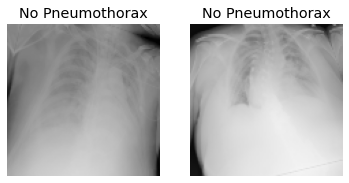

In [92]:
#dls = block.dataloaders(labels.values, item_tfms=Resize(100), bs=2)
dls.show_batch()

#Training

In [93]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [94]:
#since we did not mention the loss function explicity, fastai chooses the most appropriate loss for the task
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [95]:
#also the optimizer can be checked
learn.opt_func

<function fastai.optimizer.Adam>

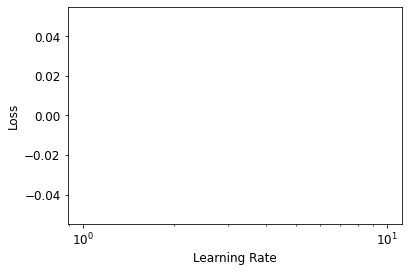

In [96]:
#let us find the best learning rate
learn.lr_find()

In [97]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.178106,1.118915,0.480000,00:07
1,1.170975,1.078653,0.580000,00:07
2,1.063870,0.872513,0.640000,00:07
3,0.990182,0.694237,0.720000,00:07
4,0.939466,0.605685,0.760000,00:07
5,0.913625,0.623595,0.760000,00:07
6,0.894804,0.848188,0.560000,00:07
7,0.780541,0.689916,0.700000,00:07
8,0.878990,0.705126,0.620000,00:07
9,0.883768,0.718757,0.620000,00:07


In [98]:
learn.save("112-model")

Path('models/112-model.pth')

In [99]:
learn.predict(dataset/f"train/Pneumothorax/000004.dcm")

('No Pneumothorax', tensor(0), tensor([0.8054, 0.1946]))

In [100]:
tta = learn.tta(use_max=True)

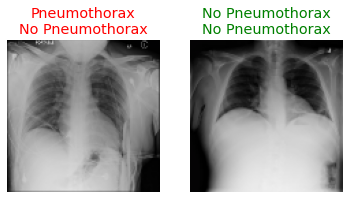

In [101]:
learn.show_results(max_n=16)

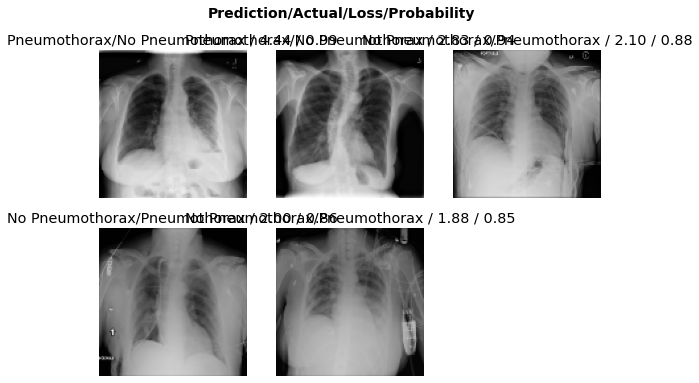

In [102]:
interpretation = Interpretation.from_learner(learn)
interpretation.plot_top_losses(5)

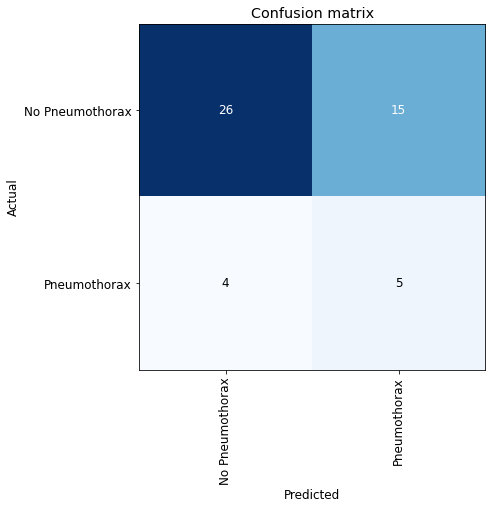

In [103]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [104]:
block = DataBlock(
    blocks=(ImageBlock(cls=PILDicom),CategoryBlock),
    get_x = lambda x: dataset/f"{x[0]}",
    get_y = lambda x: x[1],
    batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)]
)
dls = block.dataloaders(labels.values, num_workers=0,bs=2)

In [105]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)


In [106]:
learn.load('112-model')

In [ ]:
learn.lr_find()

In [108]:
learn.fit_one_cycle(10, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.715012,0.915756,0.620000,00:07
1,0.874219,0.852290,0.660000,00:07
2,0.822508,0.903440,0.640000,00:07
3,0.715849,0.896821,0.660000,00:07
4,0.713377,0.865142,0.600000,00:07
5,0.810677,0.920382,0.620000,00:07
6,0.765158,0.920909,0.580000,00:07
7,0.772807,0.974170,0.640000,00:07
8,0.862378,0.941182,0.600000,00:07
9,0.785506,0.876654,0.660000,00:07


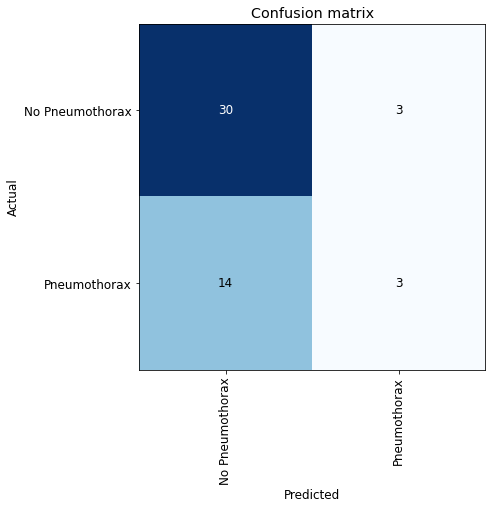

In [109]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [110]:
  #we can also reproduce the results interpreted form plot_confusion matrix
upp, low = interp.confusion_matrix()
true_negative, false_negative = upp[0], upp[1]
false_positive, true_positive = low[0], low[1]

### Sensitivity or True Positive Rate :
When a model predicts that a patient has a disease when he actually has a disease.  \
    \
Sensitivity : true_postive/(true_postive+false_negative)
    \
    \
Also called Type-II error

In [111]:
sensitivity = true_positive/(true_positive+false_negative)
sensitivity

0.5

### Specificity or True Negative Rate
When the model predicts that the patient does not have a disease when he actually does not have a disease.   \
   \
Specificity = true_negative/(true_negative+false_positive)   \
    \
Also called Type-I error

In [112]:
specificity = true_negative/(true_negative+false_positive)
specificity

0.6818181818181818

### Positive Predict Value
If the model predicts that a patient has a disease, what is the probabilty that the person actually has the condition. The idea value is 1 or 100% \
   \


In [113]:
ppv = true_positive/(true_positive+false_positive)
ppv

0.17647058823529413

### Negative Predict Value
If the model predicts that the person does not have a disease, what is the probability that the person is actually healthy. The ideal value is 1 or 100%.

In [114]:
npv = true_negative/(true_negative+false_negative)
npv

0.9090909090909091

### Accuracy in medical cases
accuracy = sensitivity *prevalence + specificity*(1-prevalence)  \
    \
prevalence is a statistical concept referring to the number of cases of the disease in a particular population at a given time.    \

The prevalence in this case is how many paients are there in the validation set compared to the total number in the val set.

In [115]:
val = dls.valid_ds.cat
print(val[0])

<bound method L.cat of TfmdLists: [['train/Pneumothorax/000021.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000230.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000151.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000069.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000088.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000135.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000154.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000030.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000165.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000144.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000193.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000096.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000033.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000226.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000220.dcm' 'No Pneumothorax']
 ['train/Pneumothorax/000223.dcm' 'Pneumothorax']
 ['train/No Pneumothorax/000133.dcm' 'No Pneumothorax']
 ['train/No Pneumothorax/000241.dcm' 'No Pne

In [116]:
prevalance = 15/50

In [117]:
accuracy = sensitivity*prevalance + specificity*(1-prevalance)
accuracy

0.6272727272727272